In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import seaborn as sns

In [30]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, FloatType, StringType
from pyspark.sql.window import Window


conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [81]:
Enteric_Fermentation_PATH = "data/global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv"
df_entric_fermentation = pd.read_csv(Enteric_Fermentation_PATH, encoding="ISO-8859-1")
df_entric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,NaN
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,NaN
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,NaN
3,2,Afghanistan,1107,Asses,5111,Stocks,1964,1964,Head,1150000.0,F
4,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,NaN


In [82]:
df_entric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value           False
Flag             True
dtype: bool

# Table description
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [83]:
df_entric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year Code', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')

Let's describe the columns of this table:

- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of animals
- **Element**: type of emission
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Year Code**
- **Unit**
- **Value**
- **Flag**: Origin of the data
 


There are no Null values except for the *Flag* column, so we will set keep_default_na to False to keep it consistent with the other tables.

In [84]:
df_entric_fermentation = pd.read_csv(Enteric_Fermentation_PATH, keep_default_na=False,encoding="ISO-8859-1")

In [85]:
df_entric_fermentation["Flag"].unique()

array(['', 'F', '*', 'Fc', 'A', 'Im'], dtype=object)

In [86]:
df_entric_fermentation["Country"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'China, Hong Kong SAR', 'China, mainland',
       'China, Taiwan Province of', 'Colombia', 'Comoros', 'Congo',
       'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Dj

In [87]:
len(df_entric_fermentation["Country"].unique())

263

This table shows the description of the different flags

In [88]:
df_flags=pd.read_csv("data/definitions_and_standards/flags.csv",keep_default_na=False,encoding = "ISO-8859-1")

In [89]:
df_flags

,Flag,Flags
0,,Official data
1,*,Unofficial figure
2,A,"Aggregate, may include official, semi-official..."
3,B,Balance
4,Bk,Break in series
5,Ce,Calculated data based on estimated data
6,Cv,Calculated through value
7,E,Expert sources from FAO (including other divis...
8,EA,Emissions computed using data from Fertilizer ...
9,F,FAO estimate


In [101]:
df_entric_fermentation["Flag"].unique()

array(['', 'F', '*', 'Fc', 'A', 'Im'], dtype=object)

In [102]:
df_entric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

Let's merge everthing in one dataframe and drop the useless columns

In [91]:
df_entric_fermentation = pd.merge(df_entric_fermentation,df_flags,on="Flag")
df_entric_fermentation.drop("Year Code",axis=1, inplace = True)
df_entric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag,Flags
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,,Official data


In [113]:
dfanimals = df_entric_fermentation[(df_entric_fermentation["Country"]=="World") & \
                       ((df_entric_fermentation["Element"]=="Emissions (CO2eq) (Enteric)")|\
                       (df_entric_fermentation["Element"]=="Emissions (CH4) (Enteric)"))]
dfanimals.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag,Flags
591534,5000,World,1107,Asses,72254,Emissions (CH4) (Enteric),1961,Gigagrams,369.5830,A,"Aggregate, may include official, semi-official..."
591535,5000,World,1107,Asses,72254,Emissions (CH4) (Enteric),1962,Gigagrams,355.9946,A,"Aggregate, may include official, semi-official..."
591536,5000,World,1107,Asses,72254,Emissions (CH4) (Enteric),1963,Gigagrams,353.7133,A,"Aggregate, may include official, semi-official..."
591537,5000,World,1107,Asses,72254,Emissions (CH4) (Enteric),1964,Gigagrams,361.1831,A,"Aggregate, may include official, semi-official..."
591538,5000,World,1107,Asses,72254,Emissions (CH4) (Enteric),1965,Gigagrams,367.6629,A,"Aggregate, may include official, semi-official..."


In [127]:
Animals = ['Asses', 'Buffaloes', 'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy',
           'Goats', 'Horses','Llamas', 'Mules','Sheep','Swine']

In [135]:
dfgrouped = dfanimals.groupby(["Item","Unit","Element"])['Value'].sum().reset_index()
dfgrouped = dfgrouped[dfgrouped["Item"].isin(Animals)]

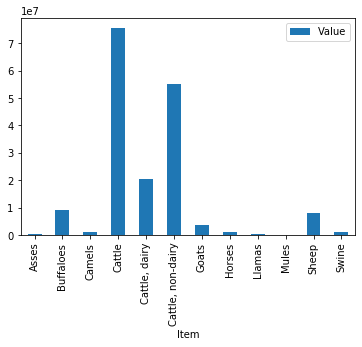

In [137]:
dfgrouped[dfgrouped["Element"]=="Emissions (CO2eq) (Enteric)"].plot.bar(x="Item",y="Value")

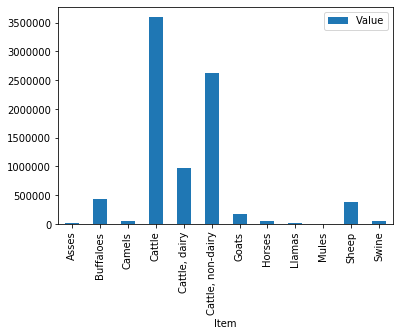

In [139]:
dfgrouped[dfgrouped["Element"]=="Emissions (CH4) (Enteric)"].plot.bar(x="Item",y="Value")

In [144]:
Manure_applied_to_soils_PATH = "data/global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv"
df_manure_applied_to_soils = pd.read_csv(Manure_applied_to_soils_PATH, encoding="ISO-8859-1")
df_manure_applied_to_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,NaN
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,NaN
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,NaN
3,2,Afghanistan,1107,Asses,5111,Stocks,1964,1964,Head,1150000.0,F
4,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,NaN


In [145]:
df_manure_applied_to_soils.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag             True
dtype: bool

In [151]:
df_manure_applied_to_soils[df_manure_applied_to_soils['Value'].isna()]["Year"].unique()

array([2030, 2050])

In [153]:
df_manure_applied_to_soils= pd.read_csv(Manure_applied_to_soils_PATH, keep_default_na=False,encoding="ISO-8859-1")

In [154]:
df_manure_applied_to_soils

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1.3e+06,
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850,
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1.00111e+06,
3,2,Afghanistan,1107,Asses,5111,Stocks,1964,1964,Head,1.15e+06,F
4,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1.3e+06,
...,...,...,...,...,...,...,...,...,...,...,...
2004792,5873,OECD,1048,Swine,72311,Emissions (CO2eq) (Manure applied),2012,2012,Gigagrams,12692.1,A
2004793,5873,OECD,1048,Swine,72311,Emissions (CO2eq) (Manure applied),2013,2013,Gigagrams,12586.6,A
2004794,5873,OECD,1048,Swine,72311,Emissions (CO2eq) (Manure applied),2014,2014,Gigagrams,12768.9,A
2004795,5873,OECD,1048,Swine,72311,Emissions (CO2eq) (Manure applied),2030,2030,Gigagrams,13578.7,A


In [162]:
df_manure_applied_to_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

In [163]:
df_manure_applied_to_soils["Item"].unique()

array(['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy',
       'Chickens, broilers', 'Chickens, layers', 'Goats', 'Horses',
       'Mules', 'Sheep', 'All Animals', 'Camels and Llamas', 'Cattle',
       'Chickens', 'Mules and Asses', 'Poultry Birds', 'Sheep and Goats',
       'Buffaloes', 'Ducks', 'Swine, breeding', 'Swine, market',
       'Turkeys', 'Swine', 'Llamas'], dtype=object)

In [169]:
animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy', 'Goats', 'Horses','Mules', 'Sheep','Cattle',
           'Chickens', 'Poultry Birds','Buffaloes', 'Ducks','Turkeys', 'Swine', 'Llamas']
dfanimals = df_manure_applied_to_soils[(df_manure_applied_to_soils["Country"]=="World") & \
                       ((df_manure_applied_to_soils["Element"]=='Emissions (N2O) (Manure applied)')|\
                       (df_manure_applied_to_soils["Element"]=='Emissions (CO2eq) (Manure applied)'))]

In [174]:
dfgrouped = dfanimals.groupby(["Item","Unit","Element"])['Value'].sum().reset_index()
dfgrouped = dfgrouped[dfgrouped["Item"].isin(animals)]

In [175]:
dfgrouped

,Item,Unit,Element,Value
2,Asses,Gigagrams,Emissions (CO2eq) (Manure applied),1.003238e+04
3,Asses,Gigagrams,Emissions (N2O) (Manure applied),3.236200e+01
4,Buffaloes,Gigagrams,Emissions (CO2eq) (Manure applied),5.290973e+05
5,Buffaloes,Gigagrams,Emissions (N2O) (Manure applied),1.706765e+03
6,Camels,Gigagrams,Emissions (CO2eq) (Manure applied),6.706597e+03
7,Camels,Gigagrams,Emissions (N2O) (Manure applied),2.163430e+01
10,Cattle,Gigagrams,Emissions (CO2eq) (Manure applied),4.822674e+06
11,Cattle,Gigagrams,Emissions (N2O) (Manure applied),1.555701e+04
12,"Cattle, dairy",Gigagrams,Emissions (CO2eq) (Manure applied),2.309397e+06
13,"Cattle, dairy",Gigagrams,Emissions (N2O) (Manure applied),7.449668e+03


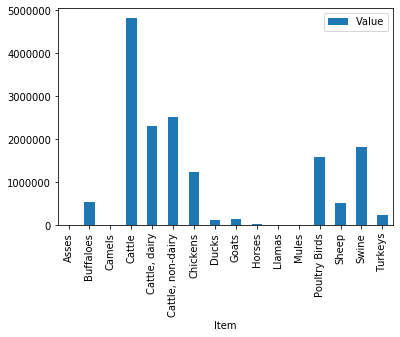

In [176]:
dfgrouped[dfgrouped["Element"]=="Emissions (CO2eq) (Manure applied)"].plot.bar(x="Item",y="Value")

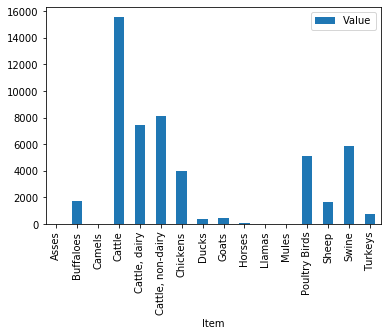

In [177]:
dfgrouped[dfgrouped["Element"]=="Emissions (N2O) (Manure applied)"].plot.bar(x="Item",y="Value")